# BioNeMo - Geneformer inferencing for single cell downstream tasks

This tutorial showcases how to run the BioNeMo container, pre-train a geneformer model, and use it for inferencing downstream single cell tasks. At the end of this tutorial, a user will learn:
- launching the BioNeMo container
- Download data from czi to use for inference.
- Convert AnnData files into the sparse CSR memmap format used by BioNeMo
- Download a pretrained checkpoint
- Restore the geneformer checkpoint and perform inference with the czi dataset.


### Prerequisites:
- BioNeMo Framework container is running (refer to the [Getting Started](../index.md) section)
- Familiarity with some components of the BioNeMo framework such as the [Models](../models/megamolbart.md) and [Inferencing](../inference-grpc-fw.md)


#### Running the BioNeMo container

This example has been built by launching the container in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multi-node launch]

Once the container is launched, navigate to http://0.0.0.0:8888, http://localhost:8888, or the IP address of the workstation/node. A JupyterLab instance should show up.

#### Copy this code and input files into JupyterLab

In the launched JupyterLab, run the codes in a Jupyter notebook as provided in the code cells below.

## Getting example single cell data and setting it up for inference

First, we must acquire single cell training data for inference. To do this we will install the cellxgene-census api and download a small dataset. We use the example provided by the czi api examples page to download a single h5ad file. Generally, our workflow expects a collection of h5ad files to be used for pre-training. In this case, we restrict to 100k cells from a single dataset  to keep training time and downloading time small.

In [1]:
!pip install cellxgene-census

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Below are paths required for setting up pre-training and inference.
tutorial_data_dir = "/workspace/bionemo/data/singlecell_inf_tutorial/download_anndata"
tutorial_processed_dir = "/workspace/bionemo/data/singlecell_inf_tutorial/processed_data"
tutorial_output_dir = "/workspace/bionemo/data/singlecell_inf_tutorial/inference_output"
tutorial_output_inference_pickle = f"{tutorial_output_dir}/human_covid19_bcells_pretrained_inference.pkl"
demo_data_download_path = f"{tutorial_data_dir}/human_covid19_bcells.h5ad"

In [3]:
!mkdir -p {tutorial_data_dir}
!mkdir -p {tutorial_processed_dir}
!mkdir -p {tutorial_output_dir}
!rm -f {tutorial_output_inference_pickle}  # clean this up if it's already there
!rm -rf {tutorial_processed_dir}

In [4]:
import cellxgene_census

with cellxgene_census.open_soma(census_version="2023-12-15") as census:
    filter1 = "cell_type == 'B cell' and tissue_general == 'lung' and disease == 'COVID-19' and is_primary_data == True"

    adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        obs_value_filter = filter1,
    )

    adata[:100000].write(demo_data_download_path)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209:

In [5]:
!ls -laht {demo_data_download_path}

-rw-r--r-- 1 jstjohn domain-users 27M May 13 16:52 /workspace/bionemo/data/singlecell_inf_tutorial/download_anndata/human_covid19_bcells.h5ad


In [6]:
!python /workspace/bionemo/bionemo/data/singlecell/sc_memmap.py \
  --data-path {tutorial_data_dir} \
  --save-path {tutorial_processed_dir}

Found 1 files
Starting to create memmap files...
Creating metadata...: 100%|███████████████████████| 1/1 [00:00<00:00,  8.48it/s]
Done creating `metadata.json`
Writing data into memmaps to /workspace/bionemo/data/singlecell_inf_tutorial/processed_data...
Merging AnnData into numpy memaps...: 100%|███████| 1/1 [00:00<00:00,  7.31it/s]
Saving dataframe ...
Done creating dataset ...


In [7]:
!ls -laht {tutorial_processed_dir}

total 19M
-rw-r--r-- 1 jstjohn domain-users 194K May 13 16:52 features.csv
drwxr-xr-x 2 jstjohn domain-users 4.0K May 13 16:52 .
-rw-r--r-- 1 jstjohn domain-users 8.5M May 13 16:52 gene_expression_ind.npy
-rw-r--r-- 1 jstjohn domain-users  19K May 13 16:52 gene_expression_ptr.npy
-rw-r--r-- 1 jstjohn domain-users 8.5M May 13 16:52 gene_expression_data.npy
-rw-r--r-- 1 jstjohn domain-users 1.1M May 13 16:52 metadata.json
drwxr-xr-x 5 jstjohn domain-users 4.0K May 13 16:52 ..


# Running inference.

Now we will use a pretrained nemo file and start there for inference. For this tutorial we'll use the large variant of our pretrained checkpoint, the 103M parameter variant based on BERT-base with enhancements from the geneformer publications.

In [8]:
!cd /workspace/bionemo/ && python download_models.py  --download_dir models geneformer_106M_240530 #--source pbss

Running command: ngc --version

NGC CLI 3.38.0

Done.


In [9]:
pretrained_nemo_file = '/workspace/bionemo/models/singlecell/geneformer/geneformer-106M-240530.nemo'

In [10]:
!python /workspace/bionemo/bionemo/model/infer.py \
  --config-dir /workspace/bionemo/examples/singlecell/geneformer/conf \
  --config-name infer \
  ++model.downstream_task.restore_from_path={pretrained_nemo_file} \
  ++model.data.batch_size=8 \
  ++model.data.dataset_path={tutorial_processed_dir} \
  ++exp_manager.exp_dir={tutorial_output_dir} \
  ++model.data.output_fname={tutorial_output_inference_pickle} 

[NeMo W 2024-05-13 16:52:39 nemo_logging:349] /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
      self.pid = os.fork()
    
[NeMo I 2024-05-13 16:52:40 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-05-13 16:52:40 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-05-13 16:52:41 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-05

# Load inference result and cluster with UMAP.
Now we will inspect our result. First, we expect there to be one prediction for each cell, we can compare the shape of the anndata object to the predictions produced by our model. After this, we can simply pass our embeddings into umap, and view the result! In this case its a very poorly trained model with very few cells, so keep expectations low!

The inference_results pickle file contains one set of hiddens and embeddings for each cell. The hiddens contain the embedding per-token, whereas the embeddings contain the mean embedding for all gene tokens with special tokens (CLS, MASK, etc) removed.

In [11]:
import pickle
with open(tutorial_output_inference_pickle, 'rb') as inference_handle:
    inference_results = pickle.load(inference_handle)
len(inference_results), inference_results[0].keys()

(2313, dict_keys(['embeddings']))

In [12]:
inference_results[0]['embeddings'].shape

(768,)

In [13]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform([x['embeddings'] for x in inference_results])

In [14]:
embedding.shape

(2313, 2)

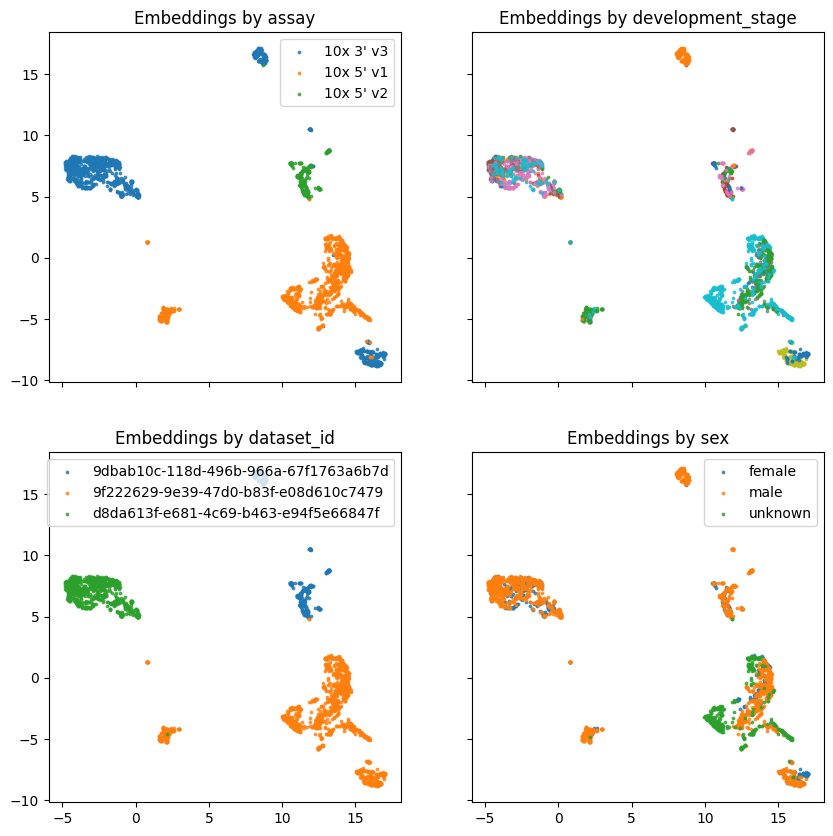

In [18]:
from matplotlib import pyplot as plt

results = adata.obs.copy()
results['x'] = embedding[:, 0]
results['y'] = embedding[:, 1]

covariates = ["assay", "development_stage", "dataset_id", "sex"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

for ax,covar in zip(axes.flat, covariates):
    for cov, cov_df in results.groupby(covar):
        ax.scatter(
            cov_df.x,
            cov_df.y,
            s=3,
            alpha=0.75,
            label=cov,
        )
    if len(results[covar].unique()) < 8:
        ax.legend()
    ax.set_title(f"Embeddings by {covar}")